<a href="https://colab.research.google.com/github/gowthamkumar9/Uber-Menternship/blob/main/Data_Modelling_%26_Model_Evaluation_Gowtham_Kumar.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Full modelling pipeline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#url = "https://docs.google.com/spreadsheets/d/1CPNki2V4VGJieVRocnr5s5A48t18Gd6sMl7IAj0k0V4/edit?usp=sharing"
#df = pd.read_csv(url)
#df.head()

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/processed_traffic_data.csv")

In [ ]:
df['DateTime'] = pd.to_datetime(df['DateTime'])
df = df.sort_values('DateTime')
df['hour'] = df['DateTime'].dt.hour
df['dayofweek'] = df['DateTime'].dt.dayofweek
df['day'] = df['DateTime'].dt.day
df['month'] = df['DateTime'].dt.month
df['is_weekend'] = df['dayofweek'].isin([5,6]).astype(int)

In [ ]:
target = 'Junction'

def make_lags(df, col, lags=[1,24,168]):
    d = df.copy()
    for l in lags:
        d[f'lag_{l}'] = d[col].shift(l)
    return d

df = make_lags(df, target)
df = df.dropna()

In [ ]:
train_size = int(len(df) * 0.8)
train = df[:train_size]
val = df[train_size:]

In [ ]:
features = ['hour','dayofweek','day','month','is_weekend'] + [c for c in df.columns if c.startswith('lag_')]
X_train = train[features]
y_train = train[target]
X_val = val[features]
y_val = val[target]

In [ ]:
scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_val_s = scaler.transform(X_val)

In [ ]:
tscv = TimeSeriesSplit(n_splits=5)
param_grid = {
    'n_estimators':[50,100],
    'learning_rate':[0.05,0.1],
    'max_depth':[3,5]
}


In [ ]:
gbr = GradientBoostingRegressor(random_state=42)
gsearch = GridSearchCV(gbr, param_grid, cv=tscv, scoring='neg_mean_squared_error')
gsearch.fit(X_train, y_train)
best_model = gsearch.best_estimator_

In [ ]:
pred = best_model.predict(X_val)
mae = mean_absolute_error(y_val, pred)
rmse = mean_squared_error(y_val, pred)
r2 = r2_score(y_val, pred)

print('MAE:', mae)
print('RMSE:', rmse)
print('R2:', r2)


MAE: 0.9995597188601968
RMSE: 1.3923191535090804
R2: -0.11394826074057018


In [ ]:
joblib.dump(best_model, 'model.joblib')
joblib.dump(scaler, 'scaler.joblib')

['scaler.joblib']

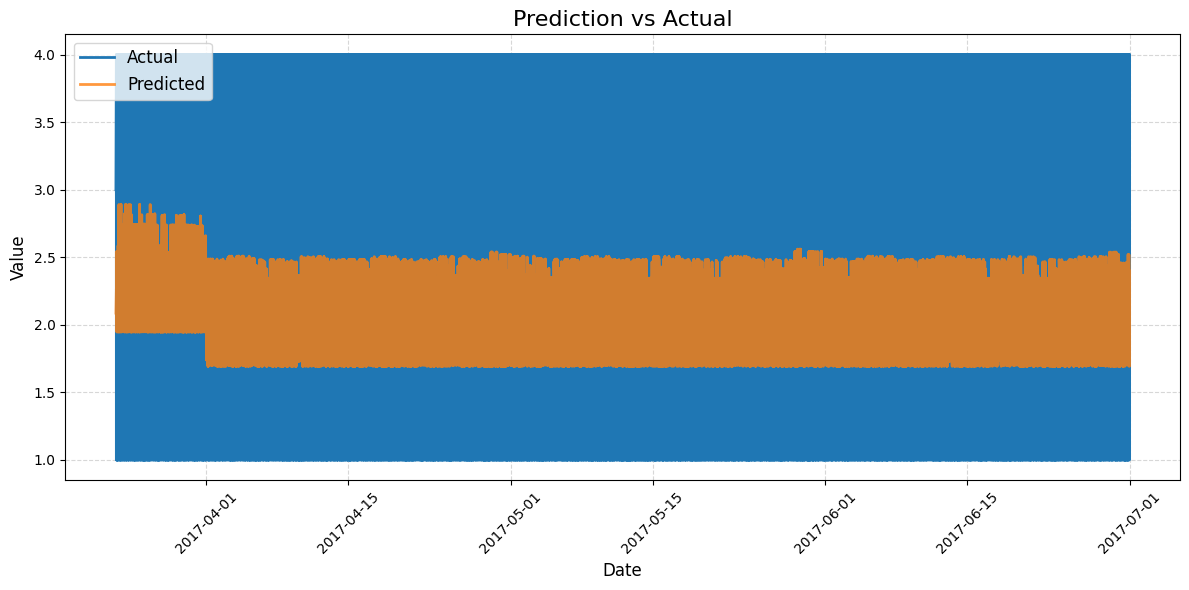

In [ ]:
plt.figure(figsize=(12, 6))  # Increase size

plt.plot(val['DateTime'], y_val, label='Actual', linewidth=2)
plt.plot(val['DateTime'], pred, label='Predicted', linewidth=2, alpha=0.8)

plt.title('Prediction vs Actual', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Value', fontsize=12)

plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.5)

plt.xticks(rotation=45)  # Better readability
plt.tight_layout()       # Removes extra white space

plt.savefig('notebook_pred_vs_actual.png')  # High-resolution
plt.show()

/tmp/ipython-input-915492948.py:16: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.tight_layout()
/tmp/ipython-input-915492948.py:17: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  plt.savefig('bar_pred_vs_actual.png')
/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


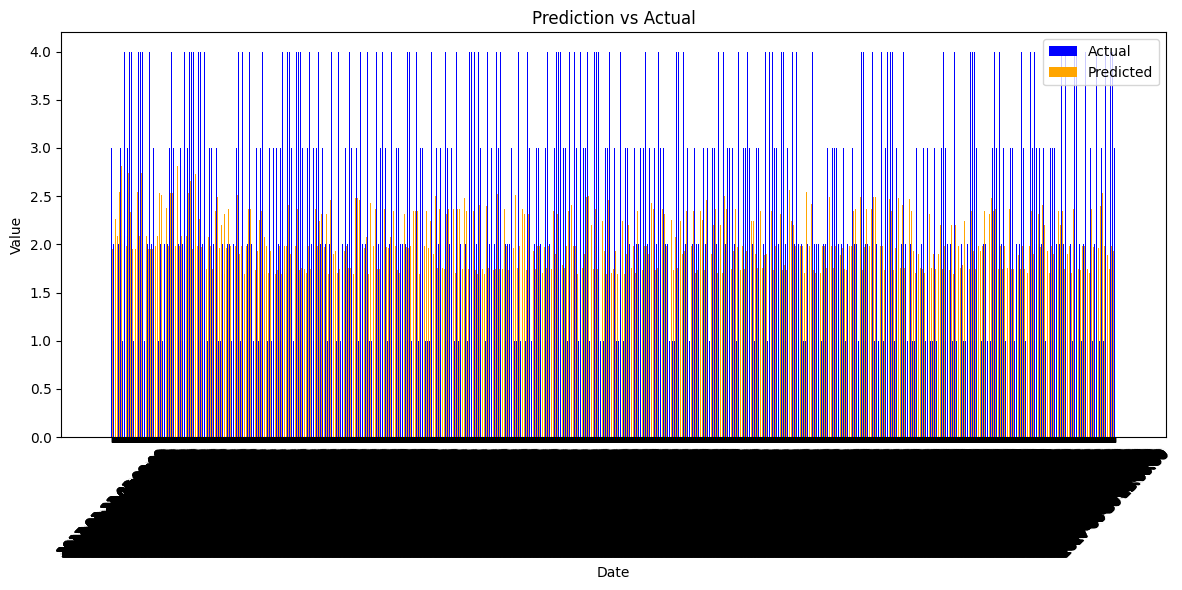

In [ ]:
# Set bar width and positions
bar_width = 0.4
x = np.arange(len(val['DateTime']))

# Create the plot
plt.figure(figsize=(12, 6))
plt.bar(x - bar_width/2, y_val, width=bar_width, label='Actual', color='blue')
plt.bar(x + bar_width/2, pred, width=bar_width, label='Predicted', color='orange')

# Format x-axis with date labels
plt.xticks(x, val['DateTime'], rotation=45)
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Prediction vs Actual')
plt.legend()
plt.tight_layout()
plt.savefig('bar_pred_vs_actual.png')
plt.show()


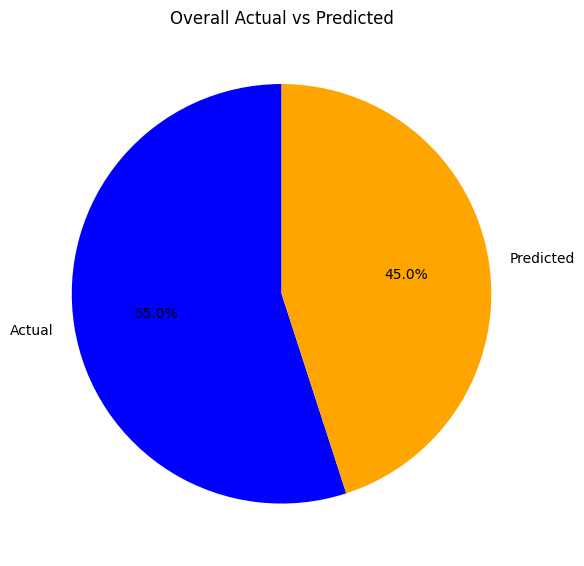

In [ ]:
actual_total = sum(y_val)
pred_total = sum(pred)

# Labels and values
labels = ['Actual', 'Predicted']
values = [actual_total, pred_total]
colors = ['blue', 'orange']

# Create pie chart
plt.figure(figsize=(6,6))
plt.pie(values, labels=labels, colors=colors, autopct='%1.1f%%', startangle=90)
plt.title('Overall Actual vs Predicted')
plt.tight_layout()
plt.savefig('pie_pred_vs_actual.png')
plt.show()
